[Learn the Basics](intro.html) \|\|
[Quickstart](quickstart_tutorial.html) \|\|
[Tensors](tensorqs_tutorial.html) \|\| [Datasets &
DataLoaders](data_tutorial.html) \|\|
[Transforms](transforms_tutorial.html) \|\| **Build Model** \|\|
[Autograd](autogradqs_tutorial.html) \|\|
[Optimization](optimization_tutorial.html) \|\| [Save & Load
Model](saveloadrun_tutorial.html)

Build the Neural Network
========================

Neural networks comprise of layers/modules that perform operations on
data. The [torch.nn](https://pytorch.org/docs/stable/nn.html) namespace
provides all the building blocks you need to build your own neural
network. Every module in PyTorch subclasses the
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
A neural network is a module itself that consists of other modules
(layers). This nested structure allows for building and managing complex
architectures easily.

In the following sections, we\'ll build a neural network to classify
images in the FashionMNIST dataset.


In [3]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Get Device for Training
=======================

We want to be able to train our model on an
[accelerator](https://pytorch.org/docs/stable/torch.html#accelerators)
such as CUDA, MPS, MTIA, or XPU. If the current accelerator is
available, we will use it. Otherwise, we use the CPU.


In [4]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Define the Class
================

We define our neural network by subclassing `nn.Module`, and initialize
the neural network layers in `__init__`. Every `nn.Module` subclass
implements the operations on input data in the `forward` method.


In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # First convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        )

        self.flatten = nn.Flatten()
        self.fc_stack = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),  # Adjusted for CNN output shape
            nn.ReLU(),
            nn.Linear(512, 10)  # Output layer for 10 classes
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.fc_stack(x)
        return logits

### 初始输入
输入图像是一个大小为 28x28 的单通道灰度图像（即张量的形状是 (1, 28, 28)）。

### 第一层卷积 (`nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)`)
- **输入通道**：1（灰度图像有1个通道）
- **输出通道**：32（卷积层会生成32个不同的特征图）
- **卷积核大小**：3x3（意味着卷积核会覆盖 3x3 的区域）
- **步幅（stride）**：1（意味着每次卷积核移动1个像素）
- **填充（padding）**：1（这意味着在输入的边缘会填充1个像素，以保持输出尺寸不变）

### 输出尺寸计算
对于卷积操作，卷积核会在输入图像上滑动，并计算每个位置的卷积值。假设输入大小为 28x28，经过一个 3x3 的卷积核，步幅为 1，且有 1 个像素的填充，那么输出图像的尺寸是：

$$
\text{Output Size} = \frac{\text{Input Size} - \text{Kernel Size} + 2 \times \text{Padding}}{\text{Stride}} + 1
$$

$$
\text{Output Size} = \frac{28 - 3 + 2 \times 1}{1} + 1 = 28
$$

也就是说，经过卷积后，图像尺寸保持 28x28（因为我们使用了填充）。并且该层输出 32 个不同的特征图，所以最终输出的形状是 **(32, 28, 28)**。


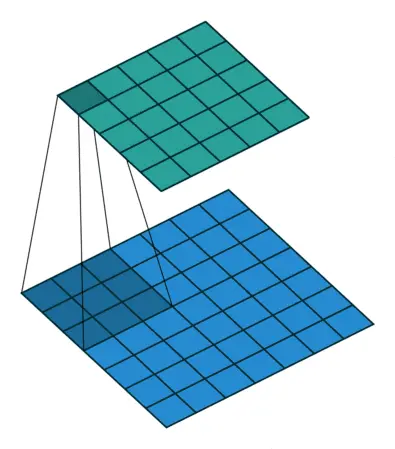

### 单通道单卷积核

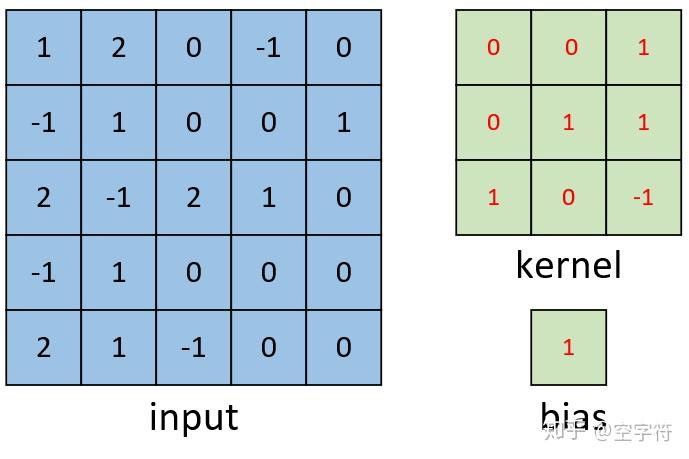

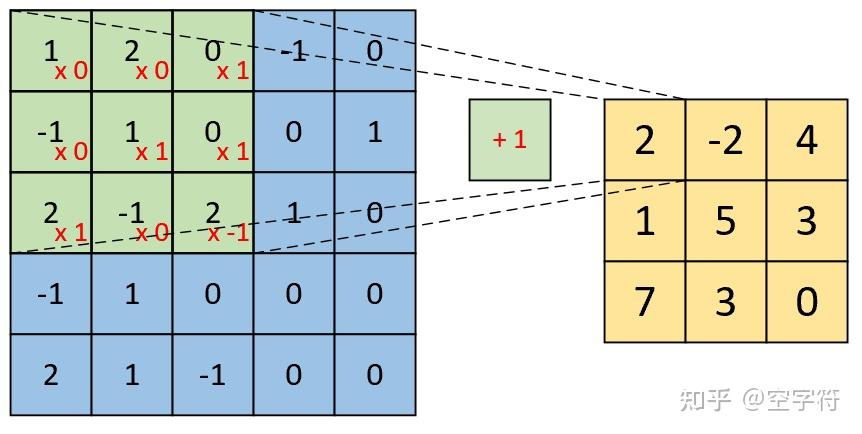

#### 单通道多卷积核
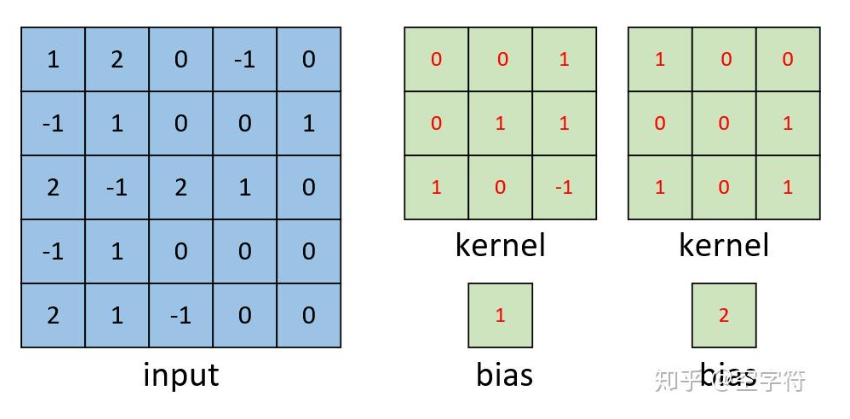

### 第一层池化 (`nn.MaxPool2d(kernel_size=2, stride=2)`)
池化层用于减少特征图的尺寸。`MaxPool2d` 是最大池化层，它会在 2x2 的区域内选择最大值。

- **池化核大小**：2x2（每个 2x2 的区域都会取最大值）
- **步幅**：2（池化核会每次移动 2 个像素）

经过池化操作，图像的尺寸会减小一半。池化后的尺寸计算方式为：

$$
\text{Output Size} = \frac{\text{Input Size} - \text{Kernel Size}}{\text{Stride}} + 1
$$

$$
\text{Output Size} = \frac{28 - 2}{2} + 1 = 14
$$

所以，经过池化后，特征图的尺寸变为 14x14，并且输出的形状是 **(32, 14, 14)**，即 32 个 14x14 的特征图。


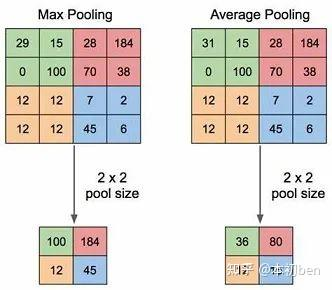

### 第二层卷积 (`nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)`)
- **输入通道**：32（上一层池化后的 32 个特征图）
- **输出通道**：64（卷积层生成 64 个特征图）
- **卷积核大小**：3x3
- **步幅（stride）**：1
- **填充（padding）**：1

同样的，通过卷积操作，输出的图像尺寸还是保持为 14x14（和第一层的卷积一样），而且生成了 64 个特征图。因此，经过这层卷积后，输出的形状是 **(64, 14, 14)**。


### 第二层池化 (`nn.MaxPool2d(kernel_size=2, stride=2)`)
- **池化核大小**：2x2
- **步幅**：2

再一次池化会将特征图的尺寸减小一半，新的尺寸是：

$$
\text{Output Size} = \frac{14 - 2}{2} + 1 = 7
$$

所以，经过第二次池化后，特征图的尺寸变为 7x7，并且输出的形状是 **(64, 7, 7)**，即 64 个 7x7 的特征图。


We create an instance of `NeuralNetwork`, and move it to the `device`,
and print its structure.


In [6]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_stack): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model\'s
`forward`, along with some [background
operations](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866).
Do not call `model.forward()` directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0
corresponding to each output of 10 raw predicted values for each class,
and dim=1 corresponding to the individual values of each output. We get
the prediction probabilities by passing it through an instance of the
`nn.Softmax` module.


------------------------------------------------------------------------


Model Layers
============

Let\'s break down the layers in the FashionMNIST model. To illustrate
it, we will take a sample minibatch of 3 images of size 28x28 and see
what happens to it as we pass it through the network.


In [10]:
input_image = torch.rand(3,64,7,7)
print(input_image.size())

torch.Size([3, 64, 7, 7])


nn.Flatten
==========

We initialize the
[nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)
layer to convert each 2D 28x28 image into a contiguous array of 784
pixel values ( the minibatch dimension (at dim=0) is maintained).


In [11]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 3136])


nn.Linear
=========

The [linear
layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
is a module that applies a linear transformation on the input using its
stored weights and biases.


In [12]:
layer1 = nn.Linear(in_features=64*7*7, out_features=512)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 512])


nn.ReLU
=======

Non-linear activations are what create the complex mappings between the
model\'s inputs and outputs. They are applied after linear
transformations to introduce *nonlinearity*, helping neural networks
learn a wide variety of phenomena.

In this model, we use
[nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
between our linear layers, but there\'s other activations to introduce
non-linearity in your model.


In [ ]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[-0.8155,  0.4364,  0.1662,  0.4308, -0.4632, -0.0608,  0.4676,  0.3582,
          0.1318, -0.3257, -0.0410,  0.1791, -0.2960,  0.0350,  0.2795,  0.1487,
          0.2711,  0.0381,  0.1622,  0.7398],
        [-0.7836,  0.1588, -0.0540,  0.0256,  0.0607,  0.0414,  0.0875,  0.5841,
         -0.1266, -0.3181, -0.1275,  0.2162, -0.0972, -0.1950, -0.1328,  0.1250,
          0.0096,  0.2308,  0.0622,  0.4636],
        [-0.6345,  0.4286, -0.1851, -0.1316, -0.4850,  0.1012,  0.1033,  0.4850,
         -0.1706, -0.4910,  0.0943,  0.4303,  0.0551, -0.5008,  0.1604, -0.0431,
          0.2507, -0.2065,  0.2412,  0.3248]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.4364, 0.1662, 0.4308, 0.0000, 0.0000, 0.4676, 0.3582, 0.1318,
         0.0000, 0.0000, 0.1791, 0.0000, 0.0350, 0.2795, 0.1487, 0.2711, 0.0381,
         0.1622, 0.7398],
        [0.0000, 0.1588, 0.0000, 0.0256, 0.0607, 0.0414, 0.0875, 0.5841, 0.0000,
         0.0000, 0.0000, 0.2162, 0.0000, 0.0000, 0.00

nn.Sequential
=============

[nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
is an ordered container of modules. The data is passed through all the
modules in the same order as defined. You can use sequential containers
to put together a quick network like `seq_modules`.


In [16]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(512, 10)
)
input_hidden = torch.rand(3,64,7,7)
logits = seq_modules(input_hidden)
logits

tensor([[ 1.2551e-01,  1.7702e-01, -2.2989e-01,  5.4732e-05,  2.6820e-02,
          3.2406e-01, -1.2575e-01, -9.6412e-03, -2.4847e-02, -1.8267e-01],
        [ 1.5082e-01,  1.2396e-01, -2.2135e-01,  3.3797e-02, -3.1211e-02,
          3.4431e-01, -5.5561e-02,  7.1908e-02, -1.7041e-01, -8.2648e-02],
        [ 1.4561e-01,  1.0062e-01, -3.3402e-01,  1.1117e-02,  1.1253e-01,
          2.6505e-01, -7.5709e-02, -4.7778e-03, -8.9497e-02, -1.5948e-01]],
       grad_fn=<AddmmBackward0>)

nn.Softmax
==========

The last linear layer of the neural network returns [logits]{.title-ref}
- raw values in \[-infty, infty\] - which are passed to the
[nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
module. The logits are scaled to values \[0, 1\] representing the
model\'s predicted probabilities for each class. `dim` parameter
indicates the dimension along which the values must sum to 1.


In [15]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

Model Parameters
================

Many layers inside a neural network are *parameterized*, i.e. have
associated weights and biases that are optimized during training.
Subclassing `nn.Module` automatically tracks all fields defined inside
your model object, and makes all parameters accessible using your
model\'s `parameters()` or `named_parameters()` methods.

In this example, we iterate over each parameter, and print its size and
a preview of its values.


In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0300, -0.0243,  0.0026,  ...,  0.0312, -0.0254, -0.0236],
        [ 0.0042,  0.0333,  0.0111,  ...,  0.0274,  0.0270, -0.0345]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0176,  0.0231], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0435,  0.0431, -0.0073,  ...,  0.0099,  0.0136,  0.0399],
        [ 0.0043, -0.0251,  0.0172,  ...,  0.0379, -0.0058, -0.0275]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

------------------------------------------------------------------------


Further Reading
===============

-   [torch.nn API](https://pytorch.org/docs/stable/nn.html)
